<a href="https://colab.research.google.com/github/loki20051267/Applications-Of-Data-Mining/blob/main/ADM_LAB_8_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

data = {
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
    'PlayTennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
}
df = pd.DataFrame(data)
le = LabelEncoder()
encoded_df = df.apply(le.fit_transform)
print("Encoded Dataset:\n", encoded_df)

Encoded Dataset:
     Outlook  Temperature  Humidity  Wind  PlayTennis
0         2            1         0     1           0
1         2            1         0     0           0
2         0            1         0     1           1
3         1            2         0     1           1
4         1            0         1     1           1
5         1            0         1     0           0
6         0            0         1     0           1
7         2            2         0     1           0
8         2            0         1     1           1
9         1            2         1     1           1
10        2            2         1     0           1
11        0            2         0     0           1
12        0            1         1     1           1
13        1            2         0     0           0


In [2]:
import numpy as np
def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    entropy_val = -np.sum([(counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy_val
def info_gain(data, feature, target_name='PlayTennis'):
    total_entropy = entropy(data[target_name])
    vals, counts = np.unique(data[feature], return_counts=True)
    weighted_entropy = np.sum([
        (counts[i]/np.sum(counts)) * entropy(data.where(data[feature] == vals[i]).dropna()[target_name])
        for i in range(len(vals))
    ])
    return total_entropy - weighted_entropy
for col in encoded_df.columns[:-1]:
    print(f'Info Gain for {col}: {info_gain(encoded_df, col)}')


Info Gain for Outlook: 0.24674981977443933
Info Gain for Temperature: 0.02922256565895487
Info Gain for Humidity: 0.15183550136234159
Info Gain for Wind: 0.04812703040826949


In [3]:
def id3(data, originaldata, features, target_attribute_name="PlayTennis", parent_node_class=None):
    from collections import Counter
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    elif len(data) == 0:
        return np.unique(originaldata[target_attribute_name])[
            np.argmax(np.unique(originaldata[target_attribute_name], return_counts=True)[1])
        ]
    elif len(features) == 0:
        return parent_node_class

    else:
        parent_node_class = np.unique(data[target_attribute_name])[
            np.argmax(np.unique(data[target_attribute_name], return_counts=True)[1])
        ]
        item_values = [info_gain(data, feature, target_attribute_name) for feature in features]
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
        tree = {best_feature: {}}
        for value in np.unique(data[best_feature]):
            sub_data = data.where(data[best_feature] == value).dropna()
            subtree = id3(sub_data, data, [i for i in features if i != best_feature], target_attribute_name, parent_node_class)
            tree[best_feature][value] = subtree
        return tree
features = list(encoded_df.columns[:-1])
tree = id3(encoded_df, encoded_df, features)
print("Decision Tree:\n", tree)

Decision Tree:
 {'Outlook': {np.int64(0): np.float64(1.0), np.int64(1): {'Wind': {np.float64(0.0): np.float64(0.0), np.float64(1.0): np.float64(1.0)}}, np.int64(2): {'Humidity': {np.float64(0.0): np.float64(0.0), np.float64(1.0): np.float64(1.0)}}}}


In [4]:
def predict(query, tree, default=1):
    for key in query.keys():
        if key in tree.keys():
            try:
                result = tree[key][query[key]]
            except:
                return default

            if isinstance(result, dict):
                return predict(query, result)
            else:
                return result
test_data = encoded_df.iloc[:3, :-1].to_dict(orient="records")
print("\nPredictions:")
for i, sample in enumerate(test_data):
    print(f"Sample {i+1} -> Prediction: {predict(sample, tree)}")


Predictions:
Sample 1 -> Prediction: 0.0
Sample 2 -> Prediction: 0.0
Sample 3 -> Prediction: 1.0



Sklearn Accuracy: 1.0


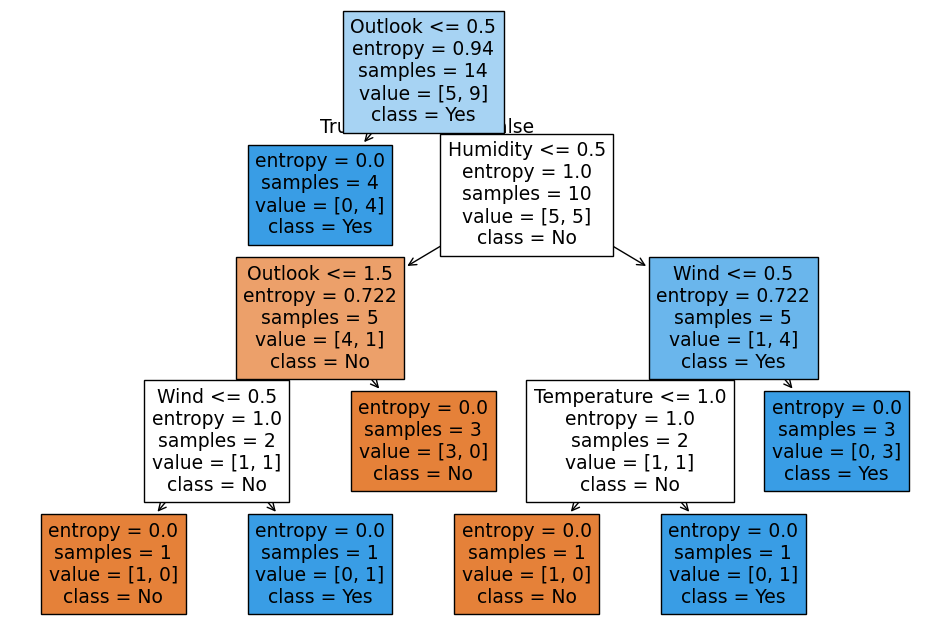

In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
X = encoded_df.drop(columns=['PlayTennis'])
y = encoded_df['PlayTennis']
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X, y)
y_pred = clf.predict(X)
print("\nSklearn Accuracy:", accuracy_score(y, y_pred))
plt.figure(figsize=(12,8))
plot_tree(clf, feature_names=X.columns, class_names=['No', 'Yes'], filled=True)
plt.show()